# Library

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.base import clone
import sys
sys.path.append("../src")
from myproject.pipelines.preprocessing_pipelinev1 import preprocessing_pipeline
from myproject.pipelines.clean_pipelinev1 import cleaning_pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    confusion_matrix
)
import optuna
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import callback as xgb_callback
import xgboost as xgboost
import numpy as np

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("credit_classification_ml")

/home/jakub/.venvs/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Experiment: artifact_location='mlflow-artifacts:/454137213308002966', creation_time=1764624674955, experiment_id='454137213308002966', last_update_time=1764624674955, lifecycle_stage='active', name='credit_classification_ml', tags={'mlflow.experimentKind': 'custom_model_development'}>

# DATA

In [2]:
#Load DataFrame
df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML (kopia)/data/raw/train.csv")

/tmp/ipykernel_3819/3472164453.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/jakub/Pulpit/Credit Classification ML (kopia)/data/raw/train.csv")


In [3]:
# Encode categorical label y
label_encoder = LabelEncoder()
df['Credit_Score_LE'] = label_encoder.fit_transform(df['Credit_Score'])
class_map = dict(enumerate(label_encoder.classes_))
print("Class mapping: ",class_map)

Class mapping:  {0: 'Good', 1: 'Poor', 2: 'Standard'}


In [4]:
#Split data to X and y
X = df.drop(columns=["Credit_Score_LE", "Credit_Score"])
y = df["Credit_Score_LE"]

print("X shape:", X.shape)
print("y shape:", y.shape)

#Split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Load cleaning and preprocessing function
clean = cleaning_pipeline()
preprocess = preprocessing_pipeline()

X shape: (100000, 27)
y shape: (100000,)


# Model Baseline

In [5]:
#Building baseline model pipeline 
xgb_base = Pipeline([
    ("clean", clean),
    ("prep", preprocess),
    ("xgb_base", XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=4
    ))
])

In [6]:
#Split data to 5 folds for cross val
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Scoring metrics for model evaluation 
scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro"
}

#Cross Validate
cv_result_base = cross_validate(
    xgb_base,
    X_train, y_train,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

#Metrics for cross validate

#Mean
cv_base_metrics_mean = {
    f"cv_{metrics}_mean_base": float(cv_result_base[f"test_{metrics}"].mean())
    for metrics in scoring.keys()
}

#Std
cv_base_metrics_std = {
    f"cv_{metrics}_std_base": float(cv_result_base[f"test_{metrics}"].std())
    for metrics in scoring.keys()
}

#Combine metrics together
cv_base_metrics = {**cv_base_metrics_mean, **cv_base_metrics_std}
pd.DataFrame([cv_base_metrics])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warni

,cv_accuracy_mean_base,cv_balanced_accuracy_mean_base,cv_f1_macro_mean_base,cv_precision_macro_mean_base,cv_recall_macro_mean_base,cv_accuracy_std_base,cv_balanced_accuracy_std_base,cv_f1_macro_std_base,cv_precision_macro_std_base,cv_recall_macro_std_base
0,0.7426,0.722854,0.723867,0.72533,0.722854,0.002704,0.002653,0.002493,0.002867,0.002653


In [7]:
#Fitting model to X_train i y_train
xgb_base.fit(X_train, y_train)


#Make predictions on X_test
y_pred_base = xgb_base.predict(X_test)

#Metrics for final evaluation
test_metrics_base = {
    "test_accuracy": accuracy_score(y_test, y_pred_base),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_base),
    "test_f1_macro": f1_score(y_test, y_pred_base, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_base, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_base, average="macro"),
}

pd.DataFrame([test_metrics_base])

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.7461,0.727862,0.728035,0.728609,0.727862


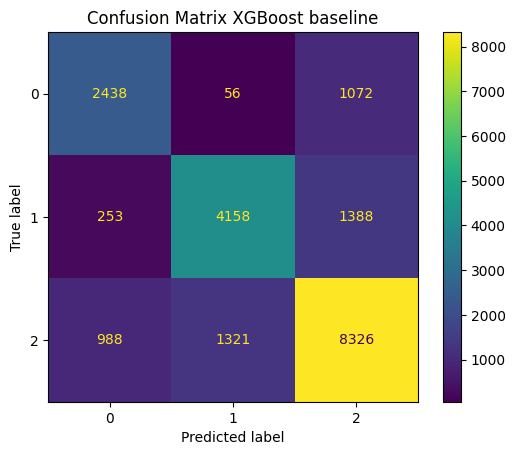

In [8]:
#Confusion Matrix 
cm = confusion_matrix(y_test, y_pred_base)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.title("Confusion Matrix XGBoost baseline")
plt.show()

In [26]:
#Log scores to mlflow
with mlflow.start_run(run_name="XGBoost_baseline"):
    mlflow.log_metrics(cv_base_metrics)
    mlflow.log_metrics(test_metrics_base)

🏃 View run XGBoost_baseline at: http://127.0.0.1:5000/#/experiments/454137213308002966/runs/dc8dc2978164408381bc81a831c9b42b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/454137213308002966


# Optuna

In [31]:
def objective(trial):
    #Function for creating new clean model with hyperparameters for Optuna
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
    }
    
    #Make model
    xgb = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        **params 
    )
    
    #Pipeline for preproces data
    pipe = Pipeline([
        ("clean",cleaning_pipeline()),
        ("prep", preprocessing_pipeline()),
        ("xgb", xgb)
    ])
    
    
    #Split data to 3 folds
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    
    """Learning process"""
    # Split X_train,y_train into fold-specific training and validation sets
    for tr_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        #Training pipeline   
        pipe.fit( X_tr, y_tr,)
    
        #Prediction on validation set
        y_val_pred = pipe.predict(X_val)
    
        #F1_macro metrics
        score = f1_score(y_val, y_val_pred, average="macro")
        scores.append(score)
    
    return float(np.mean(scores))
    

In [32]:
#Search the best params with Optuna 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2025-12-05 21:59:58,843] A new study created in memory with name: no-name-84d1922b-30e5-49a9-aee7-0ad1c0e52b1c
  0%|          | 0/20 [00:00<?, ?it/s]/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, e

[I 2025-12-05 22:00:13,736] Trial 0 finished with value: 0.6960678062070036 and parameters: {'n_estimators': 345, 'max_depth': 7, 'learning_rate': 0.02807199305554453, 'min_child_weight': 2, 'subsample': 0.602819198816191, 'colsample_bytree': 0.656876659607261, 'gamma': 2.763339944137819, 'reg_lambda': 4.883058231570675}. Best is trial 0 with value: 0.6960678062070036.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  10%|█         | 2/20 [00:48<0

[I 2025-12-05 22:00:47,774] Trial 1 finished with value: 0.7281113920368195 and parameters: {'n_estimators': 1397, 'max_depth': 7, 'learning_rate': 0.03847654423214733, 'min_child_weight': 6, 'subsample': 0.8409476357972578, 'colsample_bytree': 0.7916736606854424, 'gamma': 1.162205831568766, 'reg_lambda': 0.16526263458817414}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  15%|█▌        | 3/20 [01:06<0

[I 2025-12-05 22:01:05,635] Trial 2 finished with value: 0.679902292706723 and parameters: {'n_estimators': 960, 'max_depth': 3, 'learning_rate': 0.05083546518079454, 'min_child_weight': 4, 'subsample': 0.6935301784955843, 'colsample_bytree': 0.9216614828299773, 'gamma': 3.368260090246669, 'reg_lambda': 3.55483004584661}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  20%|██        | 4/20 [01:31<0

[I 2025-12-05 22:01:30,738] Trial 3 finished with value: 0.7012070577632495 and parameters: {'n_estimators': 1136, 'max_depth': 4, 'learning_rate': 0.24618311822471325, 'min_child_weight': 6, 'subsample': 0.9247356461946128, 'colsample_bytree': 0.8747990776589745, 'gamma': 1.1693591577914253, 'reg_lambda': 4.058313942030136}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  25%|██▌       | 5/20 [01:56<0

[I 2025-12-05 22:01:55,055] Trial 4 finished with value: 0.6864762520109428 and parameters: {'n_estimators': 653, 'max_depth': 6, 'learning_rate': 0.01029812639440828, 'min_child_weight': 9, 'subsample': 0.7789045570148108, 'colsample_bytree': 0.9692731307491405, 'gamma': 4.436892668241409, 'reg_lambda': 3.023721440720919}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  30%|███       | 6/20 [02:07<0

[I 2025-12-05 22:02:06,284] Trial 5 finished with value: 0.6984730947873553 and parameters: {'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.09690045771566991, 'min_child_weight': 3, 'subsample': 0.7848546502374258, 'colsample_bytree': 0.6342622803298693, 'gamma': 2.906146686105578, 'reg_lambda': 0.1689149396428341}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  35%|███▌      | 7/20 [02:20<0

[I 2025-12-05 22:02:18,968] Trial 6 finished with value: 0.6982950998676946 and parameters: {'n_estimators': 452, 'max_depth': 6, 'learning_rate': 0.03528541789495747, 'min_child_weight': 8, 'subsample': 0.8604388463830714, 'colsample_bytree': 0.9683207310612766, 'gamma': 2.1261150597445067, 'reg_lambda': 0.08501410132402576}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  40%|████      | 8/20 [02:35<0

[I 2025-12-05 22:02:34,596] Trial 7 finished with value: 0.6728317670086245 and parameters: {'n_estimators': 725, 'max_depth': 3, 'learning_rate': 0.01609999086242299, 'min_child_weight': 4, 'subsample': 0.849526111901086, 'colsample_bytree': 0.7076916152145833, 'gamma': 3.94562100611026, 'reg_lambda': 3.5529462357737502}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  45%|████▌     | 9/20 [02:49<0

[I 2025-12-05 22:02:47,909] Trial 8 finished with value: 0.6943540221058694 and parameters: {'n_estimators': 903, 'max_depth': 8, 'learning_rate': 0.15485115018918405, 'min_child_weight': 4, 'subsample': 0.6585695076571193, 'colsample_bytree': 0.6207695618019432, 'gamma': 4.230769895801031, 'reg_lambda': 3.0144814150570776}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  50%|█████     | 10/20 [03:13<

[I 2025-12-05 22:03:12,708] Trial 9 finished with value: 0.7185810374967708 and parameters: {'n_estimators': 917, 'max_depth': 6, 'learning_rate': 0.029132602888751715, 'min_child_weight': 9, 'subsample': 0.9515258588079849, 'colsample_bytree': 0.9825493704776279, 'gamma': 0.009517537114210883, 'reg_lambda': 1.770681530954269}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  55%|█████▌    | 11/20 [03:34<

[I 2025-12-05 22:03:33,236] Trial 10 finished with value: 0.7050802455107789 and parameters: {'n_estimators': 1477, 'max_depth': 7, 'learning_rate': 0.08592426057332252, 'min_child_weight': 7, 'subsample': 0.9884090558233618, 'colsample_bytree': 0.787093259143711, 'gamma': 1.4075075480283177, 'reg_lambda': 1.350483436722576}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 1. Best value: 0.728111:  60%|██████    | 12/20 [04:06<

[I 2025-12-05 22:04:05,185] Trial 11 finished with value: 0.7096381202043673 and parameters: {'n_estimators': 1482, 'max_depth': 5, 'learning_rate': 0.02412604791677851, 'min_child_weight': 9, 'subsample': 0.9896860515332911, 'colsample_bytree': 0.808199197295816, 'gamma': 0.03454108228035284, 'reg_lambda': 1.6126811313630454}. Best is trial 1 with value: 0.7281113920368195.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 12. Best value: 0.757108:  65%|██████▌   | 13/20 [04:56

[I 2025-12-05 22:04:54,910] Trial 12 finished with value: 0.7571081587924912 and parameters: {'n_estimators': 1225, 'max_depth': 8, 'learning_rate': 0.050806606589437725, 'min_child_weight': 10, 'subsample': 0.9013801041719702, 'colsample_bytree': 0.8071684815698402, 'gamma': 0.07300812385097274, 'reg_lambda': 1.3809592777791713}. Best is trial 12 with value: 0.7571081587924912.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 12. Best value: 0.757108:  70%|███████   | 14/20 [05:24

[I 2025-12-05 22:05:23,041] Trial 13 finished with value: 0.7387131124805486 and parameters: {'n_estimators': 1280, 'max_depth': 8, 'learning_rate': 0.06206172267929145, 'min_child_weight': 10, 'subsample': 0.8735129466743966, 'colsample_bytree': 0.7818928205988857, 'gamma': 0.8442039965681625, 'reg_lambda': 0.7699959325848994}. Best is trial 12 with value: 0.7571081587924912.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 12. Best value: 0.757108:  75%|███████▌  | 15/20 [05:49

[I 2025-12-05 22:05:48,415] Trial 14 finished with value: 0.7456036138408817 and parameters: {'n_estimators': 1191, 'max_depth': 8, 'learning_rate': 0.08232822186466539, 'min_child_weight': 10, 'subsample': 0.9073921093248688, 'colsample_bytree': 0.7209967151624642, 'gamma': 0.5508532901183669, 'reg_lambda': 1.0430609582251957}. Best is trial 12 with value: 0.7571081587924912.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 12. Best value: 0.757108:  80%|████████  | 16/20 [06:12

[I 2025-12-05 22:06:11,325] Trial 15 finished with value: 0.74475842957013 and parameters: {'n_estimators': 1161, 'max_depth': 8, 'learning_rate': 0.1272859683999057, 'min_child_weight': 10, 'subsample': 0.9113351869426991, 'colsample_bytree': 0.7170041037257027, 'gamma': 0.5574444719026608, 'reg_lambda': 2.202601540924402}. Best is trial 12 with value: 0.7571081587924912.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 12. Best value: 0.757108:  85%|████████▌ | 17/20 [06:35

[I 2025-12-05 22:06:34,206] Trial 16 finished with value: 0.7312191422412918 and parameters: {'n_estimators': 1099, 'max_depth': 8, 'learning_rate': 0.06204248126512095, 'min_child_weight': 8, 'subsample': 0.7445096748016794, 'colsample_bytree': 0.8537940477365911, 'gamma': 1.5382261892362048, 'reg_lambda': 0.9080732433111507}. Best is trial 12 with value: 0.7571081587924912.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 12. Best value: 0.757108:  90%|█████████ | 18/20 [06:53

[I 2025-12-05 22:06:52,543] Trial 17 finished with value: 0.7069154656990011 and parameters: {'n_estimators': 1284, 'max_depth': 7, 'learning_rate': 0.22312107795425498, 'min_child_weight': 10, 'subsample': 0.9057331374465427, 'colsample_bytree': 0.7352664545534455, 'gamma': 2.0396476430007695, 'reg_lambda': 2.1734416447295835}. Best is trial 12 with value: 0.7571081587924912.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 12. Best value: 0.757108:  95%|█████████▌| 19/20 [07:17

[I 2025-12-05 22:07:15,889] Trial 18 finished with value: 0.7203904320017886 and parameters: {'n_estimators': 1034, 'max_depth': 5, 'learning_rate': 0.08930412834767867, 'min_child_weight': 7, 'subsample': 0.9443219500455243, 'colsample_bytree': 0.84376142179801, 'gamma': 0.614758559901196, 'reg_lambda': 0.8773095534342472}. Best is trial 12 with value: 0.7571081587924912.


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
Best trial: 12. Best value: 0.757108: 100%|██████████| 20/20 [08:46

[I 2025-12-05 22:08:44,984] Trial 19 finished with value: 0.7527744592603113 and parameters: {'n_estimators': 1274, 'max_depth': 8, 'learning_rate': 0.159913807897008, 'min_child_weight': 1, 'subsample': 0.830114525751531, 'colsample_bytree': 0.6723408940955146, 'gamma': 0.38742772281784676, 'reg_lambda': 1.197260540941123}. Best is trial 12 with value: 0.7571081587924912.


In [16]:
print(study.best_value)
print(study.best_params)
hparams= study.best_params


0.759140779080802
{'n_estimators': 1457, 'max_depth': 8, 'learning_rate': 0.2306031138057433, 'min_child_weight': 3, 'subsample': 0.9067172916114798, 'colsample_bytree': 0.6399106696235055, 'gamma': 0.03656048098656753, 'reg_lambda': 2.234382565839864}


# Early stopping

In [33]:
#Split data for ES
X_tr_es, X_val_es, y_tr_es, y_val_es = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

#Pipeline for preprocessing data
pipe_no_model = Pipeline([
    ("clean", cleaning_pipeline()),
    ("prep", preprocessing_pipeline())
])

pipe_no_model.fit(X_tr_es, y_tr_es)
X_tr_clean = pipe_no_model.transform(X_tr_es)
X_val_clean = pipe_no_model.transform(X_val_es)

#Copy best params from Optuna
best_params = study.best_trial.params.copy()

#Create new model with best hyperparameters
xgb_es = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=4,
    random_state=42,
    **best_params,
)
        
#Pipeline for fit early stopping
xgb_es.fit(
    X_tr_clean,
    y_tr_es,
    eval_set=[(X_val_clean, y_val_es)],
    early_stopping_rounds=50,
    verbose=False
)

#Save best iteration
best_iter = xgb_es.best_iteration
print("best_iteration: ", best_iter)

#change number of nestimators
best_params["n_estimators"] = best_iter

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best_iteration:  1224


# Final Model

In [34]:
xgb_final = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    n_jobs=4,
    random_state=42,
    **best_params,

)

final_pipe = Pipeline([
    ("clean", cleaning_pipeline()),
    ("prep", preprocessing_pipeline()),
    ("xgb", xgb_final),
])

final_pipe.fit(X_train, y_train)

# train
y_train_pred = final_pipe.predict(X_train)
f1_train = f1_score(y_train, y_train_pred, average="macro")
print("TRAIN F1-macro:", f1_train)

#Final predict on X_test
y_pred_final = final_pipe.predict(X_test)

#Metrics for mlflow
test_metrics_xgb = {
    "test_accuracy": accuracy_score(y_test, y_pred_final),
    "test_balanced_accuracy": balanced_accuracy_score(y_test, y_pred_final),
    "test_f1_macro": f1_score(y_test, y_pred_final, average="macro"),
    "test_precision_macro": precision_score(y_test, y_pred_final, average="macro"),
    "test_recall_macro": recall_score(y_test, y_pred_final, average="macro"),
}
pd.DataFrame([test_metrics_xgb])


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


TRAIN F1-macro: 0.9556244861845671


/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,test_accuracy,test_balanced_accuracy,test_f1_macro,test_precision_macro,test_recall_macro
0,0.7911,0.778897,0.779425,0.779966,0.778897


In [ ]:
# #Final log paramas and metric to mlflow
# with mlflow.start_run(run_name="XGBoost_tuned"):
#     mlflow.log_params(hparams)
#     mlflow.log_metrics(test_metrics_xgb)

🏃 View run XGBoost_tuned at: http://127.0.0.1:5000/#/experiments/454137213308002966/runs/de6a96f9593548b4a5e86b9d909fbba1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/454137213308002966


# Ensemble

In [67]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

#Pipeline for preprocessing data (fit once)
pipe_e = Pipeline([
    ("clean", cleaning_pipeline()),
    ("prep", preprocessing_pipeline())
])

pipe_e.fit(X_tr, y_tr)

# Transform features only (nie transformujemy y)
X_tr_c = pipe_e.transform(X_tr)
X_val_c = pipe_e.transform(X_val)
X_test_c = pipe_e.transform(X_test)

# random state for each model
seeds = [42, 123, 777, 24, 73]
val_probs = []
test_probs = []

# training loop for all models
for seed in seeds:
    print(f"Training model with seed: {seed}")

    xgb_model = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=4,
        random_state=seed,
        enable_categorical=True,
        **best_params,
    )

    # Train the XGB on preprocessed numeric arrays (pass true y)
    xgb_model.fit(
        X_tr_c,
        y_tr,
        eval_set=[(X_val_c, y_val)],
        early_stopping_rounds=50,
        verbose=False
    )

    # Save probabilities from the trained model (używamy xgb_model, nie pipe)
    val_probs.append(xgb_model.predict_proba(X_val_c))
    test_probs.append(xgb_model.predict_proba(X_test_c))

# average probabilities and produce predictions
val_probs_mean = np.mean(val_probs, axis=0)
test_probs_mean = np.mean(test_probs, axis=0)

y_val_pred_ens = val_probs_mean.argmax(axis=1)
y_test_pred_ens = test_probs_mean.argmax(axis=1)

# poprawne metryki: walidacja vs y_val, test vs y_test
f1_val_ens = f1_score(y_val, y_val_pred_ens, average="macro")
f1_test_ens = f1_score(y_test, y_test_pred_ens, average="macro")
print("F1_macro val ensemble: ", f1_val_ens)
print("F1_macro test ensemble: ", f1_test_ens)

/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/jakub/.venvs/ml/lib/python3.12/site-packages/xgboost/sklearn.

Training model with seed: 42
Training model with seed: 123
Training model with seed: 777
Training model with seed: 24
Training model with seed: 73
F1_macro val ensemble:  0.7720577406882817
F1_macro test ensemble:  0.7675020481089073
